In [1]:
import os
import patchify as patch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from PIL import Image
from sklearn.preprocessing import MinMaxScaler , StandardScaler

Segmentation Models: using `keras` framework.


In [2]:
scaler = MinMaxScaler()
root_directory = "Semantic segmentation dataset"
patch_size = 256

In [3]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patch.patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset\Tile 1\images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset\Tile 2\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset\Tile 2\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset\T

In [4]:
#Now do the same as above for masks
#For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patch.patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_004.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_005.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_006.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_007.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_008.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_009.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

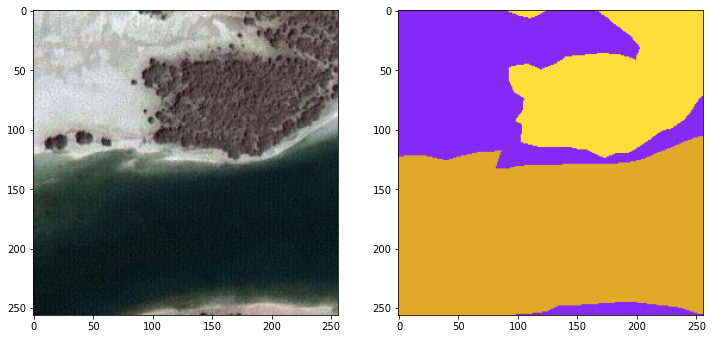

In [6]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [7]:
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


Unique labels in label dataset are:  [0 1 2 3 4 5]


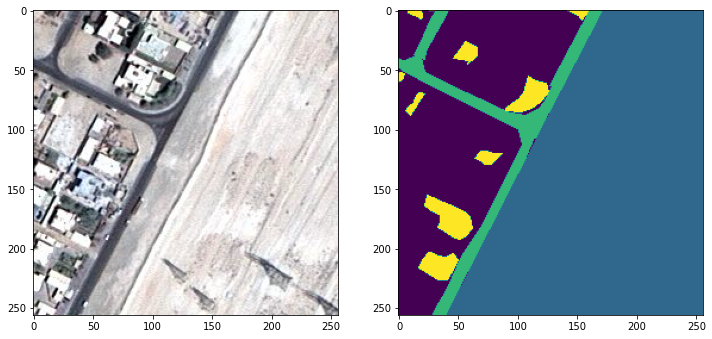

In [8]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [9]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [12]:
import Model_basic

In [ ]:
from Model_basic import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())


history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=10,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_1[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)                             64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_4[0][0]']                  
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_7 (Add)                    (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_7[0][0]']                  
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_10[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_13[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_30 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [ ]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("models/satellite_standard_unet_10epochs.hdf5",
                   custom_objects={'dice_loss_plus_2focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()